In [1]:
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import spikeinterface as si
import xarray as xr
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from aind_ephys_utils import align 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb, load_data
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import build_time_window_domain, \
                            build_spike_histogram, \
                            build_spike_histogram_overlap, \
                            fitSpikeModelP, \
                            fitSpikeModelG
import pandas as pd
import pickle

%matplotlib inline
%matplotlib widget

In [2]:
session = 'behavior_751004_2024-12-20_13-26-11'
model_name = 'stan_qLearning_5params'
session_dir = session_dirs(session, model_name = model_name)
data_type = 'curated'
curate_time = True

In [3]:
# load behavior data
session_df = makeSessionDF(session, model_name = model_name)
tblTrials = get_session_tbl(session)

In [7]:
session_df.columns

Index(['outcome', 'choice', 'laser', 'outcome_prev', 'laser_prev',
       'choices_prev', 'go_cue_time', 'choice_time', 'outcome_time', 'svs',
       'start_time', 'stop_time', 'animal_response', 'rewarded_historyL',
       'rewarded_historyR', 'delay_start_time', 'goCue_start_time',
       'reward_outcome_time', 'bait_left', 'bait_right',
       'base_reward_probability_sum', 'reward_probabilityL',
       'reward_probabilityR', 'reward_random_number_left',
       'reward_random_number_right', 'left_valve_open_time',
       'right_valve_open_time', 'block_beta', 'block_min', 'block_max',
       'min_reward_each_block', 'delay_beta', 'delay_min', 'delay_max',
       'delay_duration', 'ITI_beta', 'ITI_min', 'ITI_max', 'ITI_duration',
       'response_duration', 'reward_consumption_duration', 'reward_delay',
       'auto_waterL', 'auto_waterR', 'laser_on_trial', 'laser_wavelength',
       'laser_location', 'laser_1_power', 'laser_2_power',
       'laser_on_probability', 'laser_duration', 

In [9]:
def convert_values(value):
    if isinstance(value, str):
        try:
            # Convert NumPy-like array strings into proper lists
            if "nan" in value:
                list_array = json.loads(value.replace("nan", "null"))
                return np.array(list_array)
            elif "[" in value and "]" in value and "," in value:
                string_list = value.replace("nan", "np.nan")
                return np.array(ast.literal_eval(string_list))
            elif "[" in value and "]" in value and "," not in value:
                # return np.array(ast.literal_eval(value.replace(" ", ",")))
                return np.fromstring(value.strip("[]"), sep=" ")
            else:
                return ast.literal_eval(value)  # Convert regular lists
        except (ValueError, SyntaxError):
            return value  # If conversion fails, return original string
    return value  # Return value as-is if not a string
    
def load_drift(session, unit_id, data_type='curated'):
    session_dir = session_dirs(session)
    drift_file = os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_drift_tbl.csv')
    opto_drift_tbl = pd.read_csv(drift_file)    
    opto_drift_tbl.reset_index(drop=True, inplace=True)
    if unit_id==None:
        return opto_drift_tbl
    else:
        if unit_id in opto_drift_tbl['unit_id'].values:
            unit_drift = opto_drift_tbl[opto_drift_tbl['unit_id'] == unit_id].iloc[0].to_dict()
            # Apply conversion
            converted_data = {key: convert_values(val) for key, val in unit_drift.items()}
            unit_drift = converted_data
            return unit_drift
        else:
            return None

def get_spike_matrix(spike_times, align_time, pre_event, post_event, binSize, stepSize):
    bin_times = np.arange(pre_event, post_event, stepSize) - 0.5*stepSize
    spike_matrix = np.zeros((len(align_time), len(bin_times)))
    for i, t in enumerate(align_time):
        for j, b in enumerate(bin_times):
            spike_matrix[i, j] = np.sum((spike_times >= t + b - 0.5*binSize) & (spike_times < t + b + 0.5*binSize))
    spike_matrix = spike_matrix / binSize
    return spike_matrix, bin_times

def plot_filled_sem(time, y_mat, color, ax, label):
    ax.plot(time, np.nanmean(y_mat, 0), c = color, label = label)
    sem = np.std(y_mat, axis = 0)/np.sqrt(np.shape(y_mat)[0])
    ax.fill_between(time, np.nanmean(y_mat, 0) - sem, np.nanmean(y_mat, 0) + sem, color = color, alpha = 0.25, edgecolor = None)

def plot_raster_rate(
    spike_times,
    currArray,
    slide_times,
    align_events, # sorted by certain value
    map_value,
    bins,
    labels,
    colormap,
    fig,
    subplot_spec,
    tb=-2,
    tf=3,
):
    n_colors = len(bins)-1
    color_list = [colormap(i / (n_colors - 1)) for i in range(n_colors)]

    """Plot raster and rate aligned to events"""
    nested_gs = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios= [3, 1], subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(nested_gs[0, 0])
    ax2 = fig.add_subplot(nested_gs[1, 0])

    # order events by values
    sort_ind = np.argsort(map_value)
    align_events = align_events[sort_ind]

    df = align.to_events(spike_times, align_events, (tb, tf), return_df=True)
    
    # vertical line at time 0
    ax1.axvline(x=0, c="r", ls="--", lw=1, zorder=1)

    # raster plot
    ax1.scatter(df.time, df.event_index, c="k", marker="|", s=1)

    # horizontal line for each type if discrete
    if len(np.unique(map_value)) <= 4:
        discrete_types = np.sort(np.unique(map_value))
    else:
        discrete_types = bins
    
    for val in discrete_types:
        level = np.sum(map_value <= val)
        ax1.axhline(y=level, c="k", ls="--", lw=1)

    ax1.set_title(' '.join(labels))
    ax1.set_xlim(tb, tf)
    ax1.set_ylabel('__'.join(labels))

    # rate plot by binned values

    for bin_ind in range(len(bins)-1): 
        currList = np.where((np.array(map_value)>=bins[bin_ind]) & (np.array(map_value)<bins[bin_ind + 1]))[0]
        if len(currList) > 0:
            M = currArray[currList, :]
            plot_filled_sem(slide_times, M, color_list[bin_ind], ax2, labels[bin_ind])

    ax2.legend()

    ax2.set_title("spike rate")
    ax2.set_xlim(tb, tf)
    ax2.set_xlabel("Time from alignment (s)")

    return fig, ax1, ax2

def plot_rate(
    currArray, 
    align_events, # sorted by certain value
    map_value,
    bins,
    labels,
    colormap,
    fig,
    subplot_spec,
    tb,
    tf,
):
    n_colors = len(bins)-1
    color_list = [colormap(i / (n_colors - 1)) for i in range(n_colors)]

    """Plot raster and rate aligned to events"""
    # order events by values
    sort_ind = np.argsort(map_value)
    align_events = align_events[sort_ind]

    df = align.to_events(spike_times, align_events, (tb, tf), return_df=True)
    ax = fig.add_subplot(subplot_spec)

    # horizontal line for each type if discrete
    if len(np.unique(map_value)) <= 4:
        discrete_types = np.sort(np.unique(map_value))
    else:
        discrete_types = bins
    
    for val in discrete_types:
        level = np.sum(map_value <= val)
        ax.axhline(y=level, c="k", ls="--", lw=1)

    ax.set_title(' '.join(labels))
    ax.set_xlim(tb, tf)
    ax.set_ylabel('__'.join(labels))

    # rate plot by binned values

    for bin_ind in range(len(bins)-1): 
        currList = np.where((np.array(map_value)>=bins[bin_ind]) & (np.array(map_value)<bins[bin_ind + 1]))[0]
        M = currArray.sel(trialInd = currList).values
        plot_filled_sem(currArray.trialTime, M, color_list[bin_ind], ax, labels[bin_ind])

    ax.legend()

    ax.set_title("spike rate")
    ax.set_xlim(tb, tf)
    ax.set_xlabel("Time from alignment (s)")

    return fig, ax


In [10]:
qm_dir = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
with open(qm_dir, 'r') as f:
    qm = json.load(f)

In [11]:
unit_tbl = get_unit_tbl(session, data_type)

In [12]:
pre_event=-1
post_event=3
binSize=0.2
stepSize=0.05
fs = 14
fsLegend = 8
formula = 'spikes ~ 1 + outcome + choice + Qchosen'
align_name = 'go_cue'

In [13]:
colors = ["blue", "white", "red"]
custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", colors)
 
def plot_unit(unit_id, data_type = data_type, align_name=align_name):
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    qc_pass = unit_tbl.query('unit_id == @unit_id')['default_qc'].values[0]
    opto_pass = unit_tbl.query('unit_id == @unit_id')['opto_pass'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    if curate_time:
        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
    if align_name == 'go_cue':
        align_time = session_df_curr['go_cue_time'].values
    elif align_name == 'response':
        align_time = session_df_curr['choice_time'].values
    spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=stepSize)
    spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=-2, post_event=2.5, 
                                                binSize=0.5, stepSize=0.2)

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 7, height_ratios=[3, 1])
    # plot session
    ax = fig.add_subplot(gs[0, 0]) 
    choice_history, reward_history, p_reward, autowater_offered, random_number, trial_time = get_history_from_nwb(session_df_curr)
    plot_foraging_session(  # noqa: C901
                    choice_history,
                    reward_history,
                    p_reward = p_reward,
                    autowater_offered = autowater_offered,
                    ax = ax,
                    legend=False,
                    ax_lim=[0, len(session_df_curr)],
                    vertical=True,
                    ) 
    ax.set_ylim(0, len(session_df_curr))
    # from start to end

    ax = fig.add_subplot(gs[0, 1])  
    df = align.to_events(spike_times_curr, align_time, (pre_event, post_event), return_df=True)
    plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
    ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1, zorder = 2)
    ax.set_xlim(pre_event, post_event)
    ax.set_ylabel('Trial number')
    ax.tick_params(axis='both', which='major')
    ax.set_ylim(0, len(session_df_curr))


    # waveform
    ax = fig.add_subplot(gs[1, 1])  
    waveform = unit_tbl.query('unit_id == @unit_id')['waveform_mean'].values[0]
    peakChannel = np.argmin(np.min(waveform, axis=0))
    peakWaveform = waveform[:,peakChannel]
    peakSD = unit_tbl.query('unit_id == @unit_id')['waveform_mean'].values[0][:,peakChannel]
    timeWF = np.array(range(len(peakWaveform)))-90
    ax.plot(timeWF, peakWaveform, color = 'k')
    ax.fill_between(timeWF, peakWaveform - peakSD/np.sqrt(499), peakWaveform + peakSD/np.sqrt(499), color = 'k', alpha = 0.1)
    ax.axhline(y=0, color = 'r', ls = '--')
    ax.set_xlabel('Time (ms)', fontsize = fs)
    ax.set_ylabel(r'$\mu$-Plot')

    # reward and no reward
    outcome_int = [int(item) for item in session_df_curr['outcome'].tolist()]
    bins = [-1, 0.5, 1.5]
    labels = ['no reward', 'reward']
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                    spike_matrix, 
                                    slide_times,
                                    align_time, 
                                    outcome_int, # sorted by certain value
                                    bins,
                                    labels, 
                                    custom_cmap,
                                    fig,
                                    gs[0, 2],
                                    tb=pre_event,
                                    tf=post_event,
                                    )
    ax1.set_title('Reward vs No Reward', fontsize = fs+2)

    # left and right
    side_int = [int(item) for item in session_df_curr['choice'].tolist()]
    bins = [-1.5, 0.5, 1.5]
    labels = ['left', 'right']
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                    spike_matrix,
                                    slide_times, 
                                    align_time, 
                                    side_int, # sorted by certain value
                                    bins,
                                    labels,
                                    custom_cmap,
                                    fig,
                                    gs[0, 3],
                                    tb=pre_event,
                                    tf=post_event,
                                    )
    ax1.set_title('Right vs Left', fontsize = fs+2)

    # rpe
    target_var = 'pe'
    bin_counts = 4
    bins = np.quantile(session_df_curr[target_var].values, np.linspace(0, 1, bin_counts+1))
    # bins = [-1.0001, -0.5, 0, 0.5, 1.0001]
    bins[0] = bins[0] - 0.0001
    bins[-1] = bins[-1] + 0.0001
    labels = ['1', '2', '3', '4']
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                    spike_matrix, 
                                    slide_times,
                                    align_time,  
                                    session_df_curr[target_var].values, # sorted by certain value
                                    bins,
                                    labels,
                                    custom_cmap,
                                    fig,
                                    gs[0, 4],
                                    tb=pre_event,
                                    tf=post_event,
                                    )
    # ax.set_yticks([])
    # ax.set_ylabel(label, fontsize = fs)
    ax1.set_title(target_var, fontsize = fs+2)


    # Qchosen
    target_var = 'Qchosen'
    bin_counts = 4
    bins = np.quantile(session_df_curr[target_var].values, np.linspace(0, 1, bin_counts+1))
    # bins = [-1.0001, -0.5, 0, 0.5, 1.0001]
    bins[0] = bins[0] - 0.0001
    bins[-1] = bins[-1] + 0.0001
    labels = ['1', '2', '3', '4']
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                    spike_matrix, 
                                    slide_times,
                                    align_time, 
                                    session_df_curr[target_var].values, # sorted by certain value
                                    bins,
                                    labels,
                                    custom_cmap,
                                    fig,
                                    gs[0, 5],
                                    tb=pre_event,
                                    tf=post_event,
                                    )

    # stay vs switch
    target_var = 'Qchosen'
    bin_counts = 4
    bins = np.quantile(session_df_curr[target_var].values, np.linspace(0, 1, bin_counts+1))
    # bins = [-1.0001, -0.5, 0, 0.5, 1.0001]
    bins[0] = bins[0] - 0.0001
    bins[-1] = bins[-1] + 0.0001
    labels = ['1', '2', '3', '4']
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                    spike_matrix, 
                                    slide_times,
                                    align_time, 
                                    session_df_curr[target_var].values, # sorted by certain value
                                    bins,
                                    labels,
                                    custom_cmap,
                                    fig,
                                    gs[0, 5],
                                    tb=pre_event,
                                    t  f=post_event,
                                    )

    # ax.set_yticks([])
    # ax.set_ylabel(label, fontsize = fs)
    ax1.set_title(target_var, fontsize = fs+2)

    # stay vs no stay
    
    
    
    if len(session_df_curr) > 100 and np.sum((spike_times_curr>=session_df_curr['go_cue_time'].values[0]) & (spike_times_curr<=session_df_curr['go_cue_time'].values[-1]))/(session_df_curr['go_cue_time'].values[-1] - session_df_curr['go_cue_time'].values[0]) > 0.1:
        # plot regresssions
        gs = gridspec.GridSpec(3, 7, height_ratios=[1, 1, 1], wspace=0.5)
        ax = fig.add_subplot(gs[0,-1])
        regressors, TvCurrU, PvCurrU, EvCurrU = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
        TvCurrUSig = TvCurrU.copy()
        TvCurrUSig[PvCurrU>=0.05] = np.nan
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0, 1, len(regressors)))
        for regress in range(1, len(regressors)):
            ax.plot(slide_times_LM, TvCurrU[:, regress], lw = 2, color = colors[regress,], label = regressors[regress])
            ax.plot(slide_times_LM, TvCurrUSig[:, regress], lw = 4, color = colors[regress,])
        ax.legend(fontsize = fsLegend)
        ax.set_xlabel(f'Time from {align_name} (s)', fontsize = fs)
        ax.set_title('T-stats', fontsize = fs)

        ax = fig.add_subplot(gs[1,-1])
        for regress in range(1, len(regressors)):
            ax.plot(slide_times_LM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])

        plt.axhline(y = -np.log10(0.05), color='r', ls = '--')
        ax.legend(fontsize = fsLegend)
        ax.set_xlabel(f'Time from {align_name} (s)', fontsize = fs)
        ax.set_title('p-value', fontsize = fs)
        plt.suptitle(f'Unit{str(unit_id)} Aligned to {align_name} default qc: {qc_pass} maybe opto: {opto_pass}', fontsize = 20) 
    # # baseline 
    # gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1,1], height_ratios=[1, 1, 1])
    # ax = fig.add_subplot(gs[2,3])
    # numBins = 3
    # rInd = np.argsort(trialData['Qr'])
    # M = []
    # for b in range(numBins):
    #     currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
    #     M.append(currM)

    # cmap = plt.get_cmap('coolwarm')
    # colors = cmap(np.linspace(0.6, 1, len(M)))
    # for b in range(numBins):
    #     ax.plot(timeBl, M[b].values, c = colors[b,:])

    # ax.set_title('Qr')

    # ax = fig.add_subplot(gs[2, 4])
    # numBins = 3
    # rInd = np.argsort(trialData['Ql'])
    # M = []
    # for b in range(numBins):
    #     currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
    #     M.append(currM)

    # cmap = plt.get_cmap('coolwarm')
    # colors = cmap(np.linspace(0.6, 1, len(M)))
    # for b in range(numBins):
    #     ax.plot(timeBl, M[b].values, c = colors[b,:])

    # ax.set_title('Ql')
    # plt.show()
    plt.tight_layout()  
    return fig

/tmp/ipykernel_8048/3019757587.py:240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


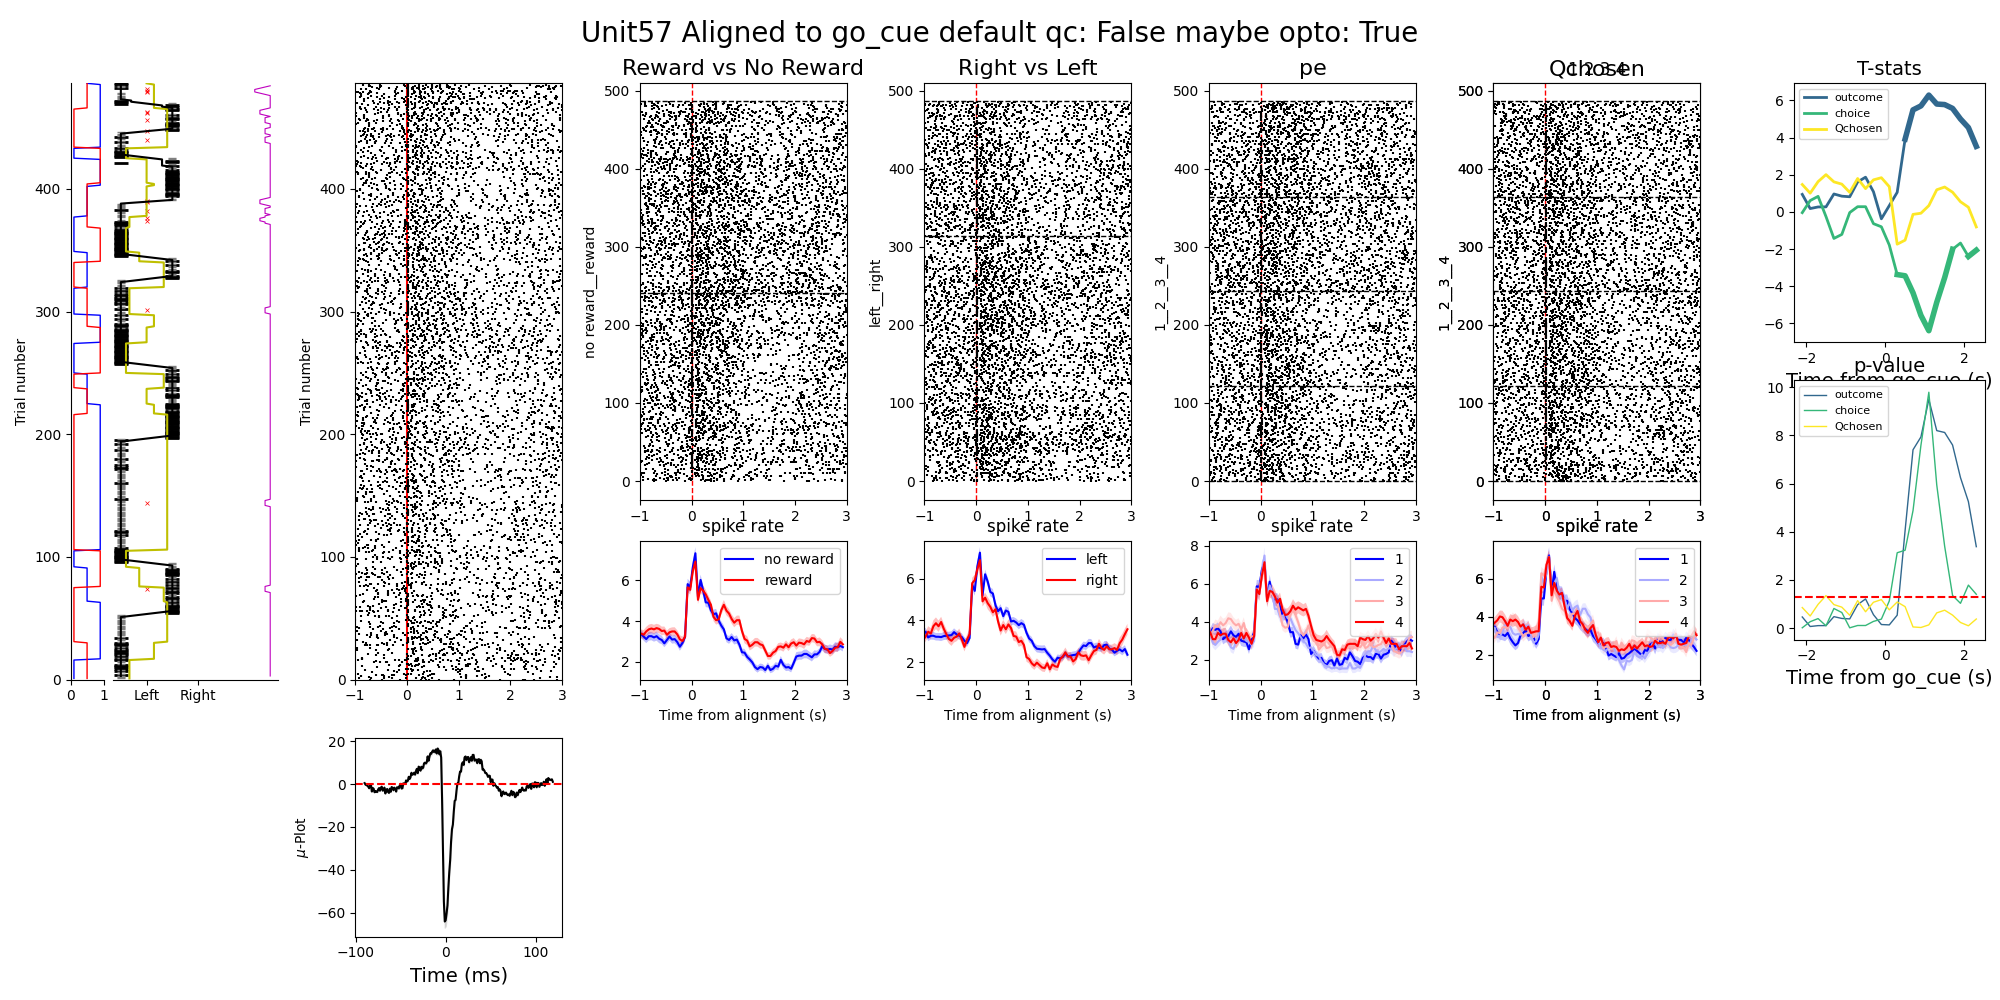

In [12]:
fig = plot_unit(57, data_type = data_type, align_name='go_cue') 

In [ ]:
def process(unit_id):
    try:
        fig = plot_unit(unit_id, data_type = data_type, align_name='go_cue')
        fig.savefig(fname=os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'unit_{unit_id}_goCue.pdf'))
        plt.close('all')
        # plt.show()
    except:
        print(f'Unit {unit_id} failed to plot')

from joblib import Parallel, delayed

Parallel(n_jobs=10)(
    delayed(process)(unit_id)
    for unit_id in unit_tbl['unit_id'].values
)



In [17]:
def process(session, data_type):
    pdf_dir = session_dir[f'ephys_fig_dir_{data_type}']
    output_pdf = os.path.join(session_dirs(session)[f'ephys_dir_{data_type}'], f'{session}_unit_beh.pdf')
    if os.path.exists(pdf_dir) and not os.path.exists(output_pdf):
        print(session)
        combine_pdf_big(pdf_dir, output_pdf)

In [18]:
process(session, data_type)

behavior_751004_2024-12-20_13-26-11
Combined PDF saved as: /root/capsule/scratch/751004/behavior_751004_2024-12-20_13-26-11/ephys/curated/behavior_751004_2024-12-20_13-26-11_unit_beh.pdf
